In [160]:
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
from itertools import permutations
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import re
from tqdm import tqdm

In [127]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
path = 'E:/individus_filtered/'
# freqs = [50, 100, 200, 300, 500, 1000, 2500, 5000, 8000, 10000, 12000, 15000]
freqs = [500, 1000, 2500, 5000, 8000, 10000, 12000, 15000, 16000,20000]
features_csv = ['downwards_mean_500', 'downwards_mean_1000', 'downwards_mean_2500',
       'downwards_mean_5000', 'downwards_mean_8000', 'downwards_mean_10000',
       'downwards_mean_12000', 'downwards_mean_15000', 'downwards_mean_16000','upwards_mean_20000','upwards_mean_5000']

## Benchmark de différents algorithmes empiriques pour la detection et l'estimation d'évenements pluvieux
#### 1-Detection:
- Ma et Nystuen, 2005, "Passive Acoustic Detection and Measurement of Rainfall at Sea"
- Nystuen, 2014, "Monitoring Greek Seas Using Passive Underwater Acoustics"
- Nystuen, 1997, "Weather Classification Using Passive Acoustic Drifters"

#### 2-Estimation:
- KK Noufal, 2025, "Rainfall estimation through ambient noise measurements in the deep waters of the southeast Arabian Sea"
- Anagnostou, 2008, "Evaluation of Underwater Rainfall Measurements During the Ionian Sea Rainfall Experiment"
- Pensieri, 2015, "Evaluation of Underwater Rainfall Measurements During the Ionian Sea Rainfall Experiment"
- Nystuen, 2014, "Monitoring Greek Seas Using Passive Underwater Acoustics"
- Ma et Nystuen, 2005, "Passive Acoustic Detection and Measurement of Rainfall at Sea"
- Nystuen, 1997, "Weather Classification Using Passive Acoustic Drifters"

# 1 Detection

In [157]:
def apply_bounds(data, bounds):
    mean_bounds = np.nanmean(bounds) 
    data_mean = np.nanmean(data)     
    offset = mean_bounds - data_mean 
    return data + offset


In [154]:
def plot_spl(df, x="upwards_mean_20000", y="upwards_mean_5000", ax=None):
    tp = df['tp']
    colors = np.where(tp == 0, 'gray', 
              np.where(tp < 0.001, 'lightblue', 'darkblue'))
    
    ax.scatter(df[x], df[y], c=colors, alpha=0.2)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Pas de pluie',
               markerfacecolor='gray', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Bruine',
               markerfacecolor='lightblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Pluie',
               markerfacecolor='darkblue', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right')

def plot_all_spl(df, features, cols=5):
    pairs = list(permutations(features, 2))
    n = len(pairs)
    rows = (n + cols - 1) // cols  

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()  

    for idx, (x, y) in enumerate(pairs):
        ax = axes[idx]
        plot_spl(df, x, y, ax=ax)

    for j in range(len(pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Test de visualistaion de clusters : pluie, bruine, absence de pluie
en testant différentes combinaisons de SPL


In [122]:
depid = depids[4]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')

# plot_all_spl(df, features, cols=5)

### Visualisation repartition des données précipitation ERA par depid

In [123]:
# depid = "ml19_292b"
for depid in depids :
    df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
    print(f"{depid} | tp <0.001: [{len(df[df['tp'] < 0.001])}] | 0.001< tp <0.002: [{len(df[(df['tp'] > 0.001) & (df['tp'] < 0.002)])}] | 0.002< tp <0.005 : [{len(df[(df['tp'] > 0.002) & (df['tp'] < 0.005)])}]")


ml17_280a | tp <0.001: [1807] | 0.001< tp <0.002: [50] | 0.002< tp <0.005 : [0]
ml18_296a | tp <0.001: [3172] | 0.001< tp <0.002: [103] | 0.002< tp <0.005 : [25]
ml18_294b | tp <0.001: [2341] | 0.001< tp <0.002: [45] | 0.002< tp <0.005 : [0]
ml19_292a | tp <0.001: [2013] | 0.001< tp <0.002: [53] | 0.002< tp <0.005 : [12]
ml19_292b | tp <0.001: [3725] | 0.001< tp <0.002: [42] | 0.002< tp <0.005 : [24]
ml19_293a | tp <0.001: [1966] | 0.001< tp <0.002: [27] | 0.002< tp <0.005 : [6]
ml19_294a | tp <0.001: [3553] | 0.001< tp <0.002: [45] | 0.002< tp <0.005 : [17]
ml20_293a | tp <0.001: [166] | 0.001< tp <0.002: [0] | 0.002< tp <0.005 : [0]
ml20_296b | tp <0.001: [4766] | 0.001< tp <0.002: [148] | 0.002< tp <0.005 : [6]
ml20_313a | tp <0.001: [2500] | 0.001< tp <0.002: [50] | 0.002< tp <0.005 : [0]
ml21_295a | tp <0.001: [4044] | 0.001< tp <0.002: [79] | 0.002< tp <0.005 : [4]
ml21_305b | tp <0.001: [2210] | 0.001< tp <0.002: [13] | 0.002< tp <0.005 : [0]


# 2 Estimation

C:\Users\barsro\AppData\Local\Temp\ipykernel_12956\1476773111.py:48: RuntimeWarning: Mean of empty slice
  mean_spl = np.nanmean(value, axis=0)
c:\Users\barsro\.conda\envs\rain\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


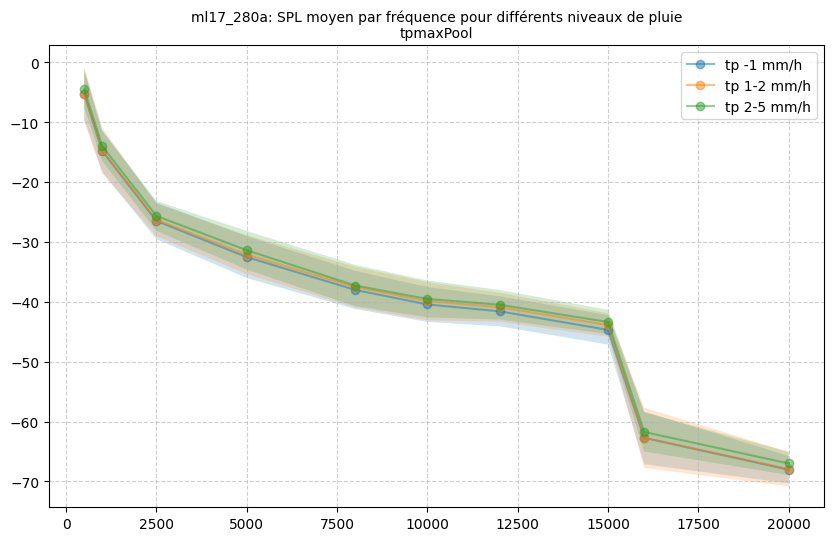

In [86]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
precip_value = 'tpmaxPool'

spll = {"-1": [], "1-2": [], "2-5": [], "5-": []}

for row in df.iterrows():
    row = row[1]
    
    if row[precip_value] < 0.001 :
        spl_000  = []
        for freq in freqs:
            if freq == 20000:
                spl_000.append(row[f"upwards_mean_{freq}"])
            else:
                spl_000.append(row[f"downwards_mean_{freq}"])
        spll["-1"].append(spl_000)

    elif 0.001 < row[precip_value] < 0.002 :
        spl_001 = []
        for freq in freqs:
            if freq == 20000:
                spl_001.append(row[f"upwards_mean_{freq}"])
            else:
                spl_001.append(row[f"downwards_mean_{freq}"])
        spll["1-2"].append(spl_001)

    elif 0.002 < row[precip_value] < 0.005 :
        spl_002 = []
        for freq in freqs:
            if freq == 20000:
                spl_002.append(row[f"upwards_mean_{freq}"])
            else:
                spl_002.append(row[f"downwards_mean_{freq}"])
        spll["2-5"].append(spl_002)

    elif row[precip_value] > 0.005 :
        spl_005 = []
        for freq in freqs:
            if freq == 20000:
                spl_005.append(row[f"upwards_mean_{freq}"])
            else:
                spl_005.append(row[f"downwards_mean_{freq}"])
        spll["5-"].append(spl_005)

plt.figure(figsize=(10, 6))
for key, value in spll.items():
    mean_spl = np.nanmean(value, axis=0)
    std_spl = np.nanstd(value, axis=0)
    if value != [] :
    # print(f"{key} : {len(value)} - {mean_spl} - {std_spl}")
        plt.plot(freqs, mean_spl, marker='o', alpha=0.5, label=f"tp {key} mm/h")
        plt.fill_between(freqs, mean_spl - std_spl, mean_spl + std_spl, alpha=0.2)
plt.legend(loc='upper right')
plt.title(f"{depid}: SPL moyen par fréquence pour différents niveaux de pluie\n{precip_value}", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()




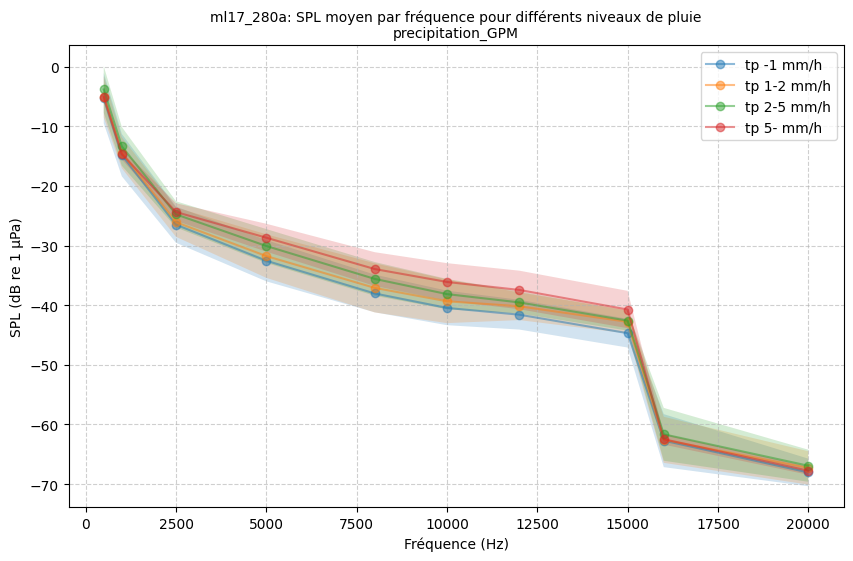

In [92]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
precip_value = 'precipitation_GPM'

spll = {"-1": [], "1-2": [], "2-5": [], "5-": []}

for row in df.iterrows():
    row = row[1]
    
    if row[precip_value] < 1 :
        spl_000  = []
        for freq in freqs:
            if freq == 20000:
                spl_000.append(row[f"upwards_mean_{freq}"])
            else:
                spl_000.append(row[f"downwards_mean_{freq}"])
        spll["-1"].append(spl_000)

    elif 1 < row[precip_value] < 2 :
        spl_001 = []
        for freq in freqs:
            if freq == 20000:
                spl_001.append(row[f"upwards_mean_{freq}"])
            else:
                spl_001.append(row[f"downwards_mean_{freq}"])
        spll["1-2"].append(spl_001)

    elif 2 < row[precip_value] < 5 :
        spl_002 = []
        for freq in freqs:
            if freq == 20000:
                spl_002.append(row[f"upwards_mean_{freq}"])
            else:
                spl_002.append(row[f"downwards_mean_{freq}"])
        spll["2-5"].append(spl_002)

    elif row[precip_value] > 5 :
        spl_005 = []
        for freq in freqs:
            if freq == 20000:
                spl_005.append(row[f"upwards_mean_{freq}"])
            else:
                spl_005.append(row[f"downwards_mean_{freq}"])
        spll["5-"].append(spl_005)

plt.figure(figsize=(10, 6))
for key, value in spll.items():
    mean_spl = np.nanmean(value, axis=0)
    std_spl = np.nanstd(value, axis=0)
    # print(f"{key} : {len(value)} - {mean_spl} - {std_spl}")
    plt.plot(freqs, mean_spl, marker='o', alpha=0.5, label=f"tp {key} mm/h")
    plt.fill_between(freqs, mean_spl - std_spl, mean_spl + std_spl, alpha=0.2)
plt.legend(loc='upper right')
plt.title(f"{depid}: SPL moyen par fréquence pour différents niveaux de pluie\n{precip_value}", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("SPL (dB re 1 µPa)")
plt.show()



### Ajout de Spectral Slope

In [152]:
depif = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
df['slope_8_15'] = df['upwards_mean_15000'] / df['upwards_mean_8000']

df.to_csv(path + f'/{depid}/{depid}_dive.csv', index=False)

In [ ]:
df.head()

### Histogramme Spectral Slope

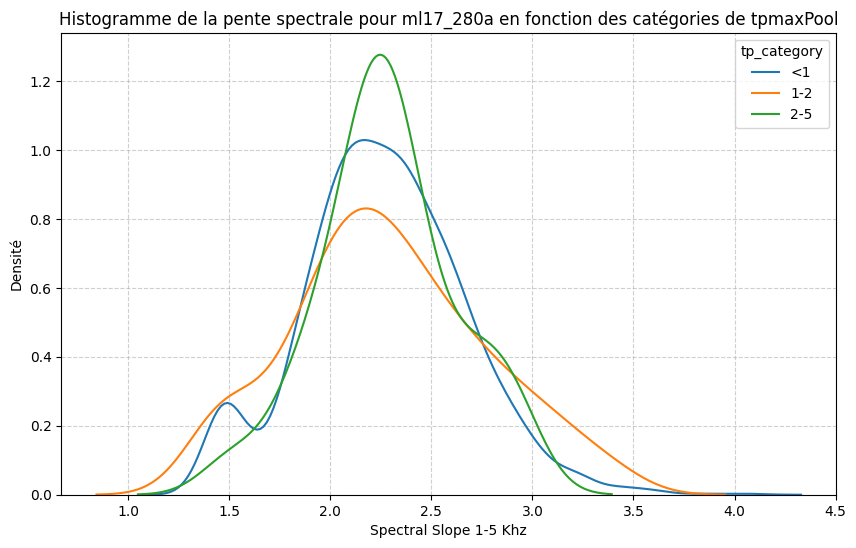

In [123]:
depif = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feat = "tpmaxPool"

if feat == "precipitation_GPM" :
    df['tp_category'] = pd.cut(df['precipitation_GPM'], bins=[0, 1, 2, 5, float('inf')], 
                            labels=['<1', '1-2', '2-5', '>5'], right=False)
else :
    df['tp_category'] = pd.cut(df['tpmaxPool'], bins=[0, 0.001, 0.002, 0.005, float('inf')], 
                            labels=['<1', '1-2', '2-5', '>5'], right=False)

# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='SpecSlope1-5', hue='tp_category')
# # sns.kdeplot(data=df, x='SpecSlope1-5', hue='tp_category',common_norm=False)
# plt.title(f"Histogramme de la pente spectrale pour {depid} en fonction des catégories de tp")
# plt.xlabel("Spectral Slope 1-5 Khz")
# plt.ylabel("densité")
# plt.legend(title='tp_category', loc='upper right')
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.show()

plt.figure(figsize=(10, 6))
for category in df['tp_category'].unique():
    sns.kdeplot(data=df[df['tp_category'] == category], x='SpecSlope1-5', label=category)
plt.title(f"Histogramme de la pente spectrale pour {depid} en fonction des catégories de {feat}")
plt.xlabel("Spectral Slope 1-5 Khz")
plt.ylabel("Densité")
plt.legend(title='tp_category', loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Plot SPL

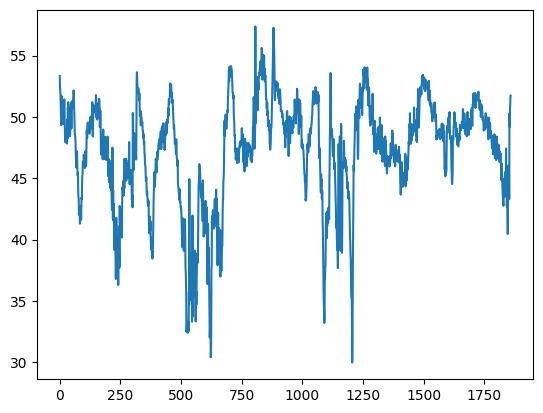

In [99]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
plt.plot(df.index, df["upwards_mean_5000"]+80, label="upwards_mean_5000 -> not modified")


### KK Noufal 

In [136]:
def RE_KKNoufal_2025(df):
    SPL_1_10kHz = df['upwards_mean_20000'] + 120
    f = 20000
    log_f = np.log10(f)
    log_5 = np.log10(5)
    R = (SPL_1_10kHz + (log_f - log_5) * 14.76 - 44.93) / ((log_f - log_5) * 5.66 + 15.75)
    return R

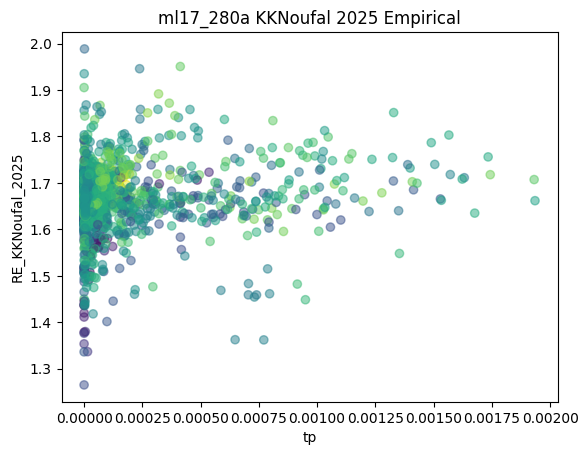

In [137]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = 'tp'

# rslts = RE_KKNoufal_2025(df[df[feature]>=0.0001])
# plt.scatter(df[df[feature]>=0.0001][feature],rslts , c=df[df[feature]>=0.0001]['wind_speed'], cmap='viridis', alpha=0.5)

rslts = RE_KKNoufal_2025(df)
plt.scatter(df[feature], rslts , c=df['wind_speed'], cmap='viridis', alpha=0.5)
plt.xlabel(f'{feature}')
plt.ylabel('RE_KKNoufal_2025')
plt.title(f"{depid} KKNoufal 2025 Empirical")
plt.show()

### ANAGNOSTOU

In [138]:
def RE_Anagnostou_2008(df):
    SPL_5Khz = df['upwards_mean_5000'] + 80
    R = (10**((SPL_5Khz - 50) / 17))
    # R = (10**((SPL_5Khz - 42.5) / 15.4))
    return R

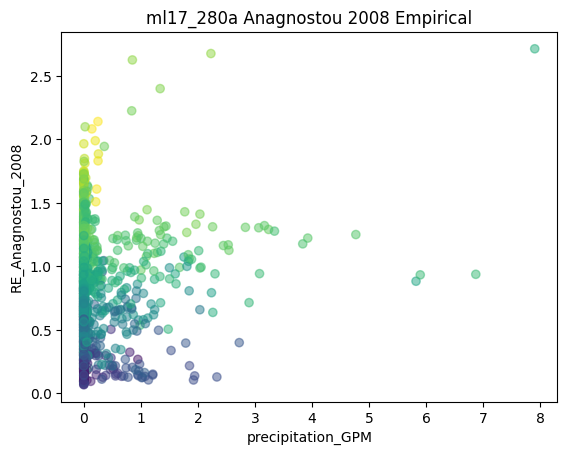

In [139]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = 'precipitation_GPM'

rslts = RE_Anagnostou_2008(df)
plt.scatter(df[feature], rslts , c=df['wind_speed'], cmap='viridis', alpha=0.5)
plt.xlabel(f'{feature}')
plt.ylabel('RE_Anagnostou_2008')
plt.title(f"{depid} Anagnostou 2008 Empirical")
plt.show()

### Nystuen

In [159]:
def DE_Nystuen_2014(df, offset=0):
    df['upwards_mean_20000'] = df['upwards_mean_20000'] + offset
    df['upwards_mean_5000'] = df['upwards_mean_5000'] + offset
    df['upwards_mean_8000'] = df['upwards_mean_8000'] + offset
    df['upwards_mean_15000'] = df['upwards_mean_15000'] + offset

    conditions = [
        # Medium rain (stratiform)
        (df['upwards_mean_20000'] > df['upwards_mean_5000'] * 0.75 + 5) & (df['upwards_mean_5000'] <= 70),

        # Heavy rain (convective)
        (df['upwards_mean_8000'] > 60) &
        (df['slope_2_8'] > -13) &
        (df['upwards_mean_20000'] > 45),

        # Drizzle
        (df['upwards_mean_8000'] < 50) &
        (df['slope_8_15'] > -5) &
        (df['upwards_mean_20000'] > 35) &
        (df['upwards_mean_20000'] > df['upwards_mean_8000'] * 0.9),

        # Rain with high winds
        (df['upwards_mean_20000'] > (-0.1144 * df['upwards_mean_8000']**2 + 12.728 * df['upwards_mean_8000'] - 307)) &
        (df['upwards_mean_20000'] < (-0.1 * df['upwards_mean_8000']**2 + 11.5 * df['upwards_mean_8000'] - 281)) &
        (df['upwards_mean_8000'] > 51) &
        (df['upwards_mean_8000'] < 64) &
        (df['slope_2_8'] > -13)
    ]

    choices = ['Medium rain (stratiform)', 'Heavy rain (convective)', 'Drizzle', 'Rain with high winds']
    df['Rain_Type'] = np.select(conditions, choices, default='None')
    return df

def RE_Nystuen_2014(df):
    SPL_5Khz = df['upwards_mean_5000'] + 95
    R = (10**(0.0325*SPL_5Khz - 1.4416) )
    return R

def RE_Nystuen_1997(df):
    SPL_5Khz = df['upwards_mean_5000'] + 80
    R = (10**((SPL_5Khz - 51.9)/10.6))
    return R

offset 14 : Rain_Type
None                       1852
Heavy rain (convective)       6
Rain with high winds          1
Name: count, dtype: int64


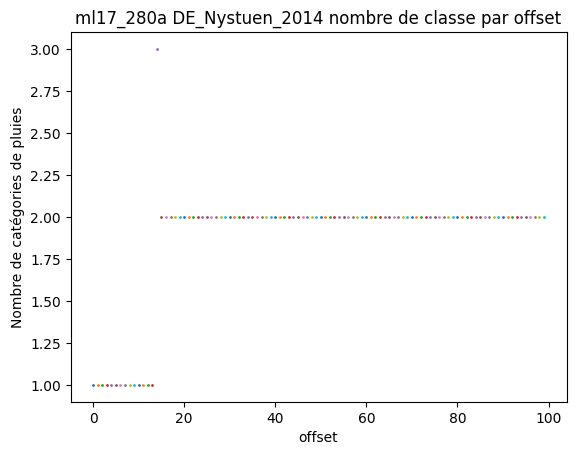

In [203]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = 'precipitation_GPM'

# plt.plot(df.index, df["upwards_mean_5000"], label="upwards_mean_5000")
# plt.plot(df.index, df["upwards_mean_8000"], label="upwards_mean_8000")
# plt.plot(df.index, df["upwards_mean_20000"], label="upwards_mean_20000")
# plt.plot(df.index, df["upwards_mean_15000"], label="upwards_mean_15000")
# plt.show()

for offset in range(0,100,1) :
    df = DE_Nystuen_2014(df, offset=offset)
    count = df['Rain_Type'].value_counts()
    plt.scatter(offset, len(count.values), label=f"offset {offset}", s=1)

    if (len(count.values)>2):
        rain_counts = df['Rain_Type'].value_counts()
        print(f"offset {offset} : {rain_counts}")
        
plt.xlabel("offset")
plt.ylabel("Nombre de catégories de pluies")
plt.title(f"{depid} DE_Nystuen_2014 nombre de classe par offset")
plt.show()

# rslts = RE_Nystuen_2014(df)
# plt.scatter(df[feature], rslts , c=df['wind_speed'], cmap='viridis', alpha=0.5)
# plt.xlabel(f'{feature}')
# plt.ylabel('RE_Nystuen_2014')
# plt.title(f"{depid} RE_Nystuen_2014")
# plt.show()

# rslts = RE_Nystuen_1997(df)
# plt.scatter(df[feature], rslts , c=df['wind_speed'], cmap='viridis', alpha=0.5)
# plt.xlabel(f'{feature}')
# plt.ylabel('RE_Nystuen_1997')
# plt.title(f"{depid} RE_Nystuen_1997")
# plt.show()

### Pensieri 2014

In [142]:
def RE_Pensieri_2014(df):
    SPL_5Khz = df['upwards_mean_5000'] + 80
    R = (10**((SPL_5Khz - 64.402)/25))
    return R

### All Models

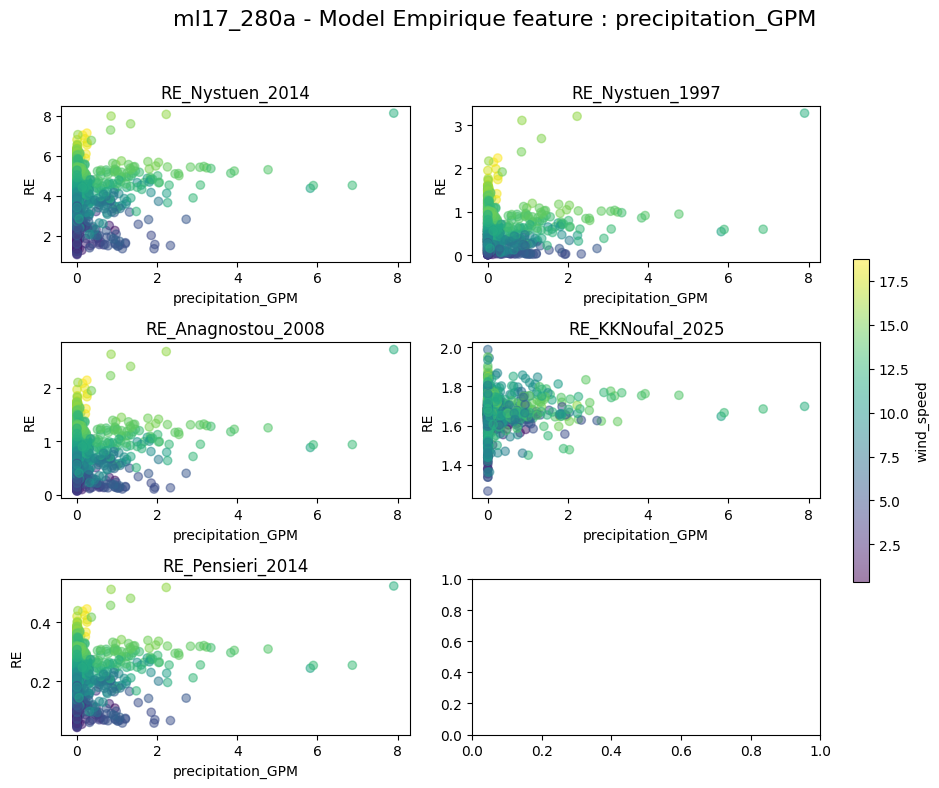

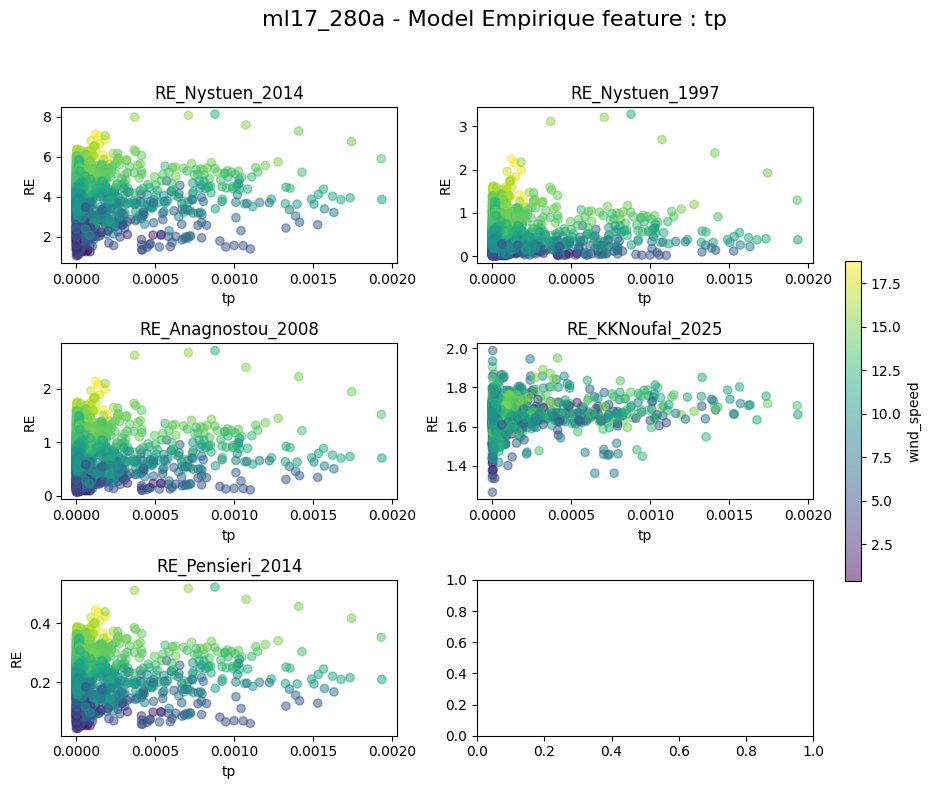

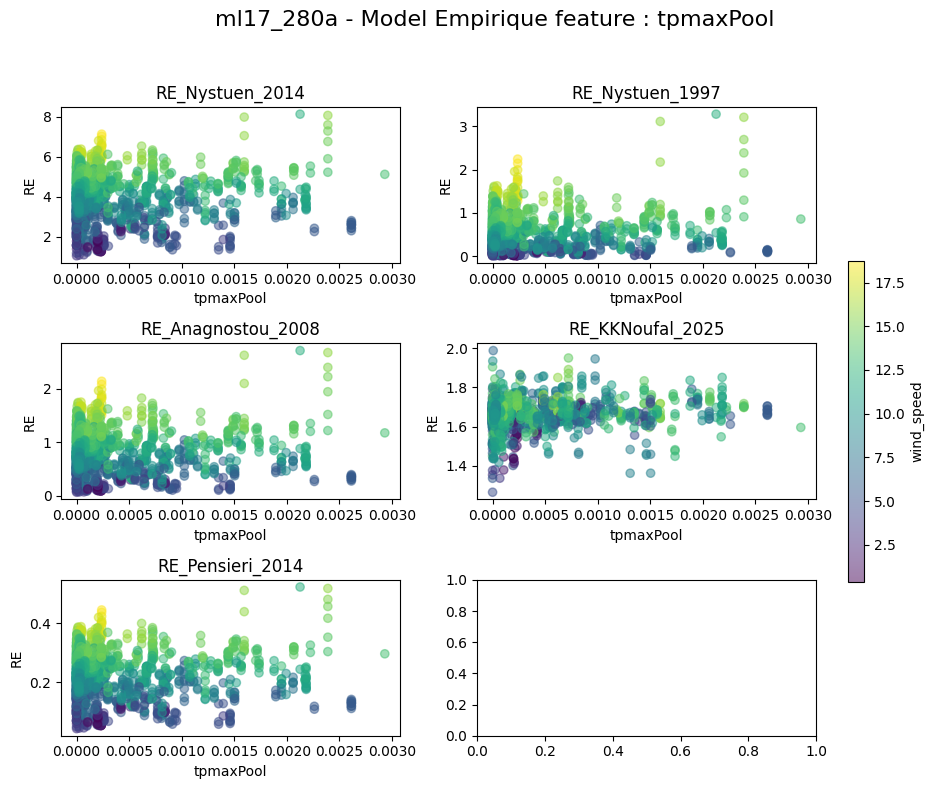

In [143]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
features = ['precipitation_GPM','tp','tpmaxPool']

for feature in features:
    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle(f"{depid} - Model Empirique feature : {feature}", fontsize=16)

    # -------- Plot 1: Nystuen 2014
    rslts = RE_Nystuen_2014(df)
    sc1 = axs[0, 0].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[0, 0].set_title('RE_Nystuen_2014')
    axs[0, 0].set_xlabel(feature)
    axs[0, 0].set_ylabel('RE')

    # -------- Plot 2: Nystuen 1997
    rslts = RE_Nystuen_1997(df)
    sc2 = axs[0, 1].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[0, 1].set_title('RE_Nystuen_1997')
    axs[0, 1].set_xlabel(feature)
    axs[0, 1].set_ylabel('RE')

    # -------- Plot 3: Anagnostou 2008
    rslts = RE_Anagnostou_2008(df)
    sc3 = axs[1, 0].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[1, 0].set_title('RE_Anagnostou_2008')
    axs[1, 0].set_xlabel(feature)
    axs[1, 0].set_ylabel('RE')

    # -------- Plot 4: KKNoufal 2025
    rslts = RE_KKNoufal_2025(df)
    sc4 = axs[1, 1].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[1, 1].set_title('RE_KKNoufal_2025')
    axs[1, 1].set_xlabel(feature)
    axs[1, 1].set_ylabel('RE')

    # -------- Plot 5: Pensieri 2014
    rslts = RE_Pensieri_2014(df)
    sc5 = axs[2, 0].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[2, 0].set_title('RE_Pensieri_2014')
    axs[2, 0].set_xlabel(feature)
    axs[2, 0].set_ylabel('RE')

    # -------- Layout + colorbar
    fig.tight_layout(rect=[0, 0, 0.9, 0.95])
    cbar = fig.colorbar(sc4, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('wind_speed')

    plt.show()


# Insertion SPL .csv

In [150]:
depid="ml17_280a"
inst = Wind(depid=depid, path=os.path.join(path,depid), acoustic_path=os.path.join(path,depid,'dives'))
inst.fetch_data(method = 'upwards', aggregation = 'mean', frequency = 15000)


c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit\applications\Wind.py:129: RuntimeWarning: Mean of empty slice
  spl.append(agg(_data['spectro'][np.isin(_data['time'], time_mask), idx_freq]))
c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit\applications\Wind.py:130: RuntimeWarning: Mean of empty slice
  wind_speed.append(agg(dive.ds['wind_speed'][:].data[(dive.ds['dives'][:].data == row.dive) & mask]))


   upwards_mean_5000  upwards_mean_20000
0         -26.661006          -66.859617
1         -27.652079          -66.281385
2         -27.933528          -66.525741
3         -28.120321          -65.920599
4         -29.029614          -66.512066
5         -30.214419          -66.905235
6         -30.668219          -69.134592
7         -30.133075          -68.765811
8         -28.329591          -68.719231
9         -28.779328          -67.734357
4 valeurs manquantes


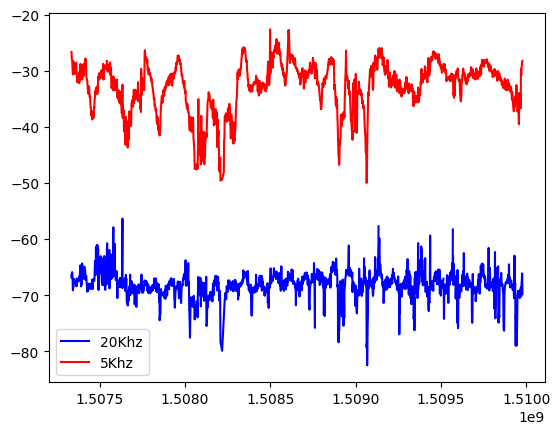

In [5]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
plt.plot(df['begin_time'], df['upwards_mean_20000'], label='20Khz',c='b')
plt.plot(df['begin_time'], df['upwards_mean_5000'], label='5Khz',c='r')
plt.legend()
plt.show()

# Yang by Nystuen val 

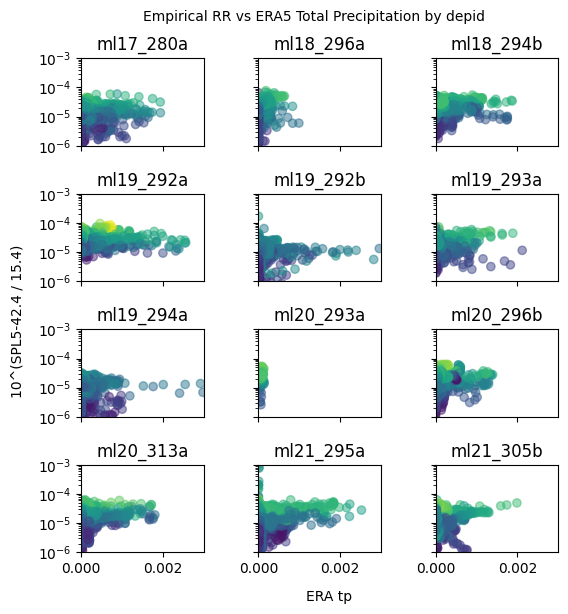

In [116]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.flatten()

wind_min, wind_max = np.inf, -np.inf
for depid in depids:
    df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
    w = df["wind_speed"].dropna()
    wind_min = min(wind_min, w.min())
    wind_max = max(wind_max, w.max())

for i, depid in enumerate(depids):
    df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
    _df = df[['upwards_mean_5000', 'tp', 'wind_speed']].copy()
    # _df = _df.melt(id_vars='tp').dropna()
    _df['Emp_RR'] = 10**((_df["upwards_mean_5000"]-42.4)/15.4)

    sc = ax[i].scatter(_df['tp'], _df['Emp_RR'],
                       c=_df["wind_speed"],
                       cmap="viridis",
                       vmin=wind_min, vmax=wind_max,
                       alpha=0.5)    
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yscale('log')
    ax[i].set_ylim(0.000001,0.001)
    ax[i].set_xlim(0,0.003)
    ax[i].set_title(depid)

fig.text(0.25,1,"Empirical RR vs ERA5 Total Precipitation by depid")
fig.text(0.56, 0.04, 'ERA tp', ha='center', va='center', fontsize=10)
fig.text(0.04, 0.5, "10^(SPL5-42.4 / 15.4)", ha='center', va='center', rotation='vertical', fontsize=10)

fig.tight_layout(rect=[0.05, 0.05, 1, 1])

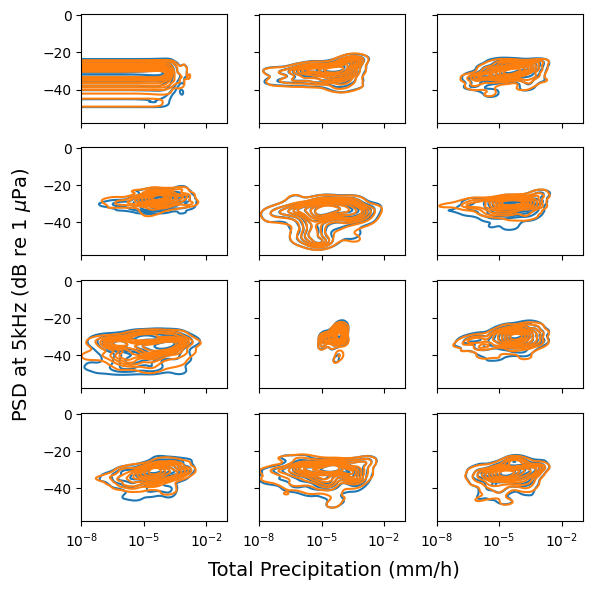

In [32]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(6, 6))
ax = ax.flatten()
for i, depid in enumerate(depids):
    df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
    _df = df[['upwards_mean_5000', 'downwards_mean_5000', 'tp']]
    _df = _df.melt(id_vars='tp').dropna()
    _df = _df[_df['tp'] >0.00000001]
    _df.columns = ['Total Precipitation (m/h)', 'variable', r'PSD at 5kHz (dB re 1 $\mu$Pa)']
    sns.kdeplot(
        data=_df,
        x='Total Precipitation (m/h)',
        y=r'PSD at 5kHz (dB re 1 $\mu$Pa)',
        hue="variable",
        ax=ax[i],
        legend = False)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_xscale('log')
    ax[i].set_xlim(0.00000001,0.1)

fig.text(0.56, 0.04, 'Total Precipitation (m/h)', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, r'PSD at 5kHz (dB re 1 $\mu$Pa)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])


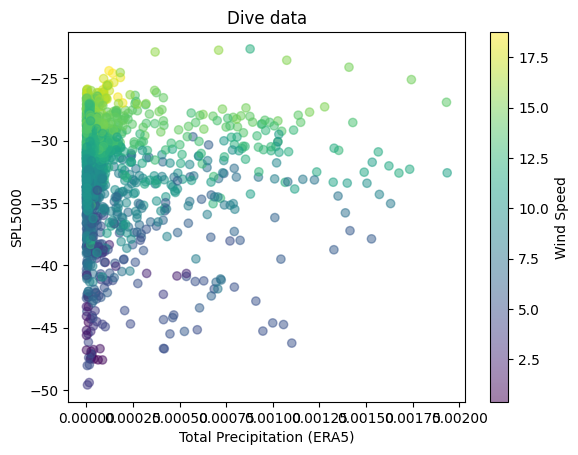

In [17]:
depid ='ml17_280a'
d_path = os.path.join(path,depid,f"{depid}_dive.csv")
df = pd.read_csv(d_path)
df = df[df['tp'] != 0]

plt.title('Dive data')
plt.scatter(df['tp'],df['upwards_mean_5000'], c=df['wind_speed'], cmap='viridis', alpha=0.5)

plt.xlabel('Total Precipitation (ERA5)')
plt.ylabel('SPL5000')
plt.colorbar(label='Wind Speed')
plt.show()

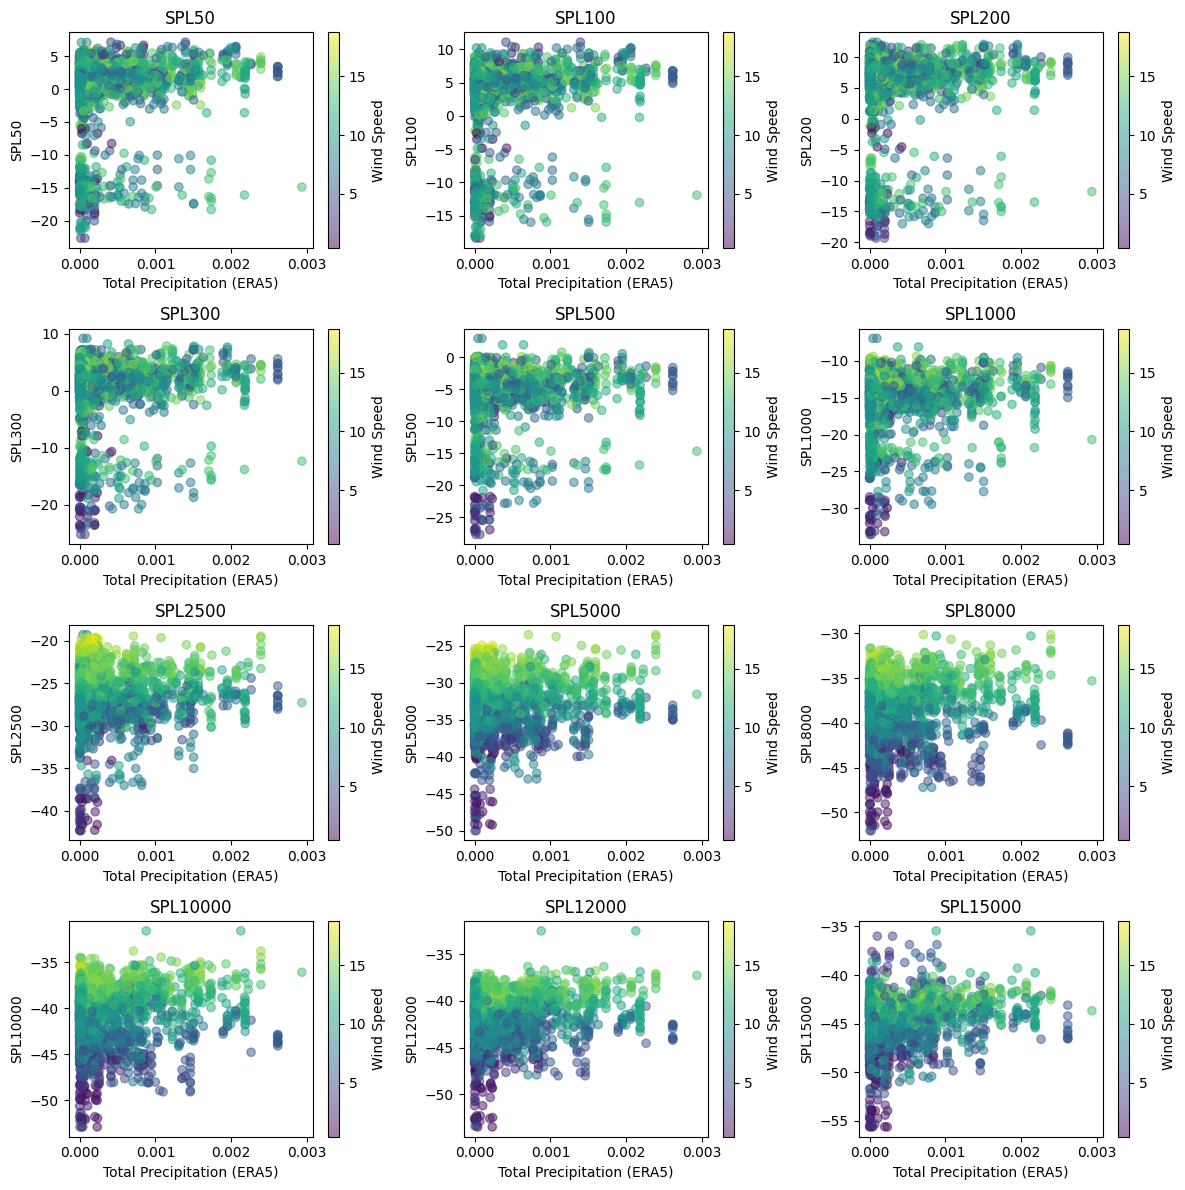

In [9]:
n_cols = 3
n_rows = int(np.ceil(len(freqs) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()
for i, freq in enumerate(freqs):
    ax = axes[i]
    ax.scatter(df['tpmaxPool'], df[f'downwards_mean_{freq}'], c=df['wind_speed'], cmap='viridis', alpha=0.5)
    ax.set_title(f'SPL{freq}')
    ax.set_xlabel('Total Precipitation (ERA5)')
    ax.set_ylabel(f'SPL{freq}')
    # ax.set_xscale('log')
    # ax.set_xlim(0.00000001,0.1)
    scatter = ax.scatter(df['tp'], df[f'downwards_mean_{freq}'], c=df['wind_speed'], cmap='viridis', alpha=0.5)
    fig.colorbar(scatter, ax=ax, label='Wind Speed')

plt.tight_layout()
# plt.savefig("../../data-exploration/exports/empirical_rain-SPL-TP(ERA5).png", dpi=300)
plt.show()
